In [ ]:
%%file romberg.f
* routine to find one interpolated value given a table of n values
* need a routine that handles a vector of inputs. But this is what
* romberg requires.
      SUBROUTINE polint(xx,yy,n,x,y,err,c,d)
c
cf2py intent(out) :: y
cf2py intent(out) :: err
cf2py intent(hide) :: n
cf2py intent(hide) :: c
cf2py intent(hide) :: d
cf2py integer :: n
cf2py real*8,dimension(n) :: xx
cf2py real*8,dimension(n) :: yy
cf2py real*8,dimension(n) :: c
cf2py real*8,dimension(n) :: d
cf2py real*8 :: x
cf2py real*8 :: y
cf2py real*8 :: err
c
      INTEGER n
      REAL*8 err,x,y,xx(n),yy(n)
      INTEGER i,m,ns
      REAL*8 den,dif,dift,ho,hp,w,c(n),d(n)
      ns=1
      dif=ABS(x-xx(1))
      DO i=1,n
        dift=ABS(x-xx(i))
        IF (dift.LT.dif) THEN
          ns=i
          dif=dift
        ENDIF
        c(i)=yy(i)
        d(i)=yy(i)
      END DO
      y=yy(ns)
      ns=ns-1
      DO m=1,n-1
        DO i=1,n-m
           ho=xx(i)-x
           hp=xx(i+m)-x
           w=c(i+1)-d(i)
           den=ho-hp
           IF(den.EQ.0.)PAUSE 'failure in polint'
           den=w/den
           d(i)=hp*den
           c(i)=ho*den
        END DO
        IF (2*ns.LT.n-m)THEN
           err=c(ns+1)
        ELSE
           err=d(ns)
           ns=ns-1
        ENDIF
        y=y+err
      END DO
      RETURN
      END

      SUBROUTINE trapzd(func,a,b,sin,sout,n)
c
cf2py intent(out) :: sout
cf2py integer :: n
cf2py real*8 :: a
cf2py real*8 :: b
cf2py real*8 :: sin
cf2py real*8 :: sout
      EXTERNAL func
cf2py a = func(b)
c
      INTEGER n
      REAL*8 a,b,sin,sout,func
      INTEGER it,j
      REAL*8 del,sum,tnm,x
      IF (n.EQ.1) THEN
        sout=0.5d0*(b-a)*(func(a)+func(b))
      ELSE
        it=2**(n-2)
        tnm=it
        del=(b-a)/tnm
        x=a+0.5d0*del
        sum=0.d0
        DO j=1,it
           sum=sum+func(x)
           x=x+del
        END DO
        sout=0.5d0*(sin+(b-a)*sum/tnm)
      ENDIF
      RETURN
      END


      SUBROUTINE qromb(func,a,b,ss,dss,numcalls,EPS,K,c,d)
c
cf2py intent(out) :: ss
cf2py intent(out) :: dss
cf2py intent(out) :: numcalls
cf2py real*8,optional :: EPS /1.e-6/
cf2py integer,optional :: K /5/
cf2py intent(hide) :: c
cf2py intent(hide) :: d
cf2py real*8,dimension(K) :: c
cf2py real*8,dimension(K) :: d
cf2py real*8 :: a
cf2py real*8 :: b
cf2py real*8 :: ss
      EXTERNAL func
cf2py real*8 :: y1
cf2py real*8 :: y2
cf2py y1 = func(y2)
c
      INTEGER JMAX,JMAXP,K,numcalls
      REAL*8 a,b,func,ss,EPS,c(k),d(k)
c     PARAMETER (EPS=1.e-6, JMAX=20, JMAXP=JMAX+1, K=5, KM=K-1)
      PARAMETER (JMAX=20,JMAXP=JMAX+1)
      INTEGER KM
      INTEGER j
      REAL*8 dss,h(JMAXP),s(JMAXP),sold
      h(1)=1.d0
      KM=K-1
      sold=0.0d0
      DO j=1,JMAX
        CALL trapzd(func,a,b,sold,s(j),j)
        IF (j.GE.K) THEN
          CALL polint(h(j-KM),s(j-KM),K,0.d0,ss,dss,c,d)
          IF (ABS(dss).LE.EPS*ABS(ss))THEN
             numcalls=2**(j-1)+1
             RETURN
          END IF
        ENDIF
        sold=s(j)
        h(j+1)=0.25d0*h(j)
      END DO
c     no convergence. Return this via numcalls
      numcalls=-1
      END






Writing romberg.f


In [ ]:
!python -m pip install msvc-runtime

ERROR: Could not find a version that satisfies the requirement msvc-runtime (from versions: none)
ERROR: No matching distribution found for msvc-runtime


In [ ]:
import os ,sys

In [ ]:
!python -m numpy.f2py -c -m romberg_module romberg.f


Traceback (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/dist-packages/numpy/f2py/__main__.py", line 5, in <module>
    main()
  File "/usr/local/lib/python3.10/dist-packages/numpy/f2py/f2py2e.py", line 766, in main
    run_compile()
  File "/usr/local/lib/python3.10/dist-packages/numpy/f2py/f2py2e.py", line 594, in run_compile
    build_backend = f2py_build_generator(backend_key)
  File "/usr/local/lib/python3.10/dist-packages/numpy/f2py/_backends/__init__.py", line 6, in f2py_build_generator
    from ._distutils import DistutilsBackend
  File "/usr/local/lib/python3.10/dist-packages/numpy/f2py/_backends/_distutils.py", line 3, in <module>
    from numpy.distutils.core import setup, Extension
  File "/usr/local/lib/python3.10/dist-packages/numpy/distutils/core.py", lin

In [ ]:
from scipy import *
from matplotlib.pyplot import *
import scipy.special as sp
import romberg_module as r
import numpy as np
# integrate sin(x) as a test
print(r"Testing Trapzd ...")
s=0.0 # initialize the integral to zero
I0=np.cos(0.0)-np.cos(1.0) # the exact value to compare with
print("i\tI[i]\tError")# print a heading
for i in range(1,10):
    s=r.trapzd(lambda x:np.sin(x),0,1,s,i)
    print("%1d %.8f %.2e" % (i,s,s-I0))

Testing Trapzd ...
i	I[i]	Error
1 0.42073549 -3.90e-02
2 0.45008052 -9.62e-03
3 0.45730094 -2.40e-03
4 0.45909897 -5.99e-04
5 0.45954804 -1.50e-04
6 0.45966028 -3.74e-05
7 0.45968834 -9.35e-06
8 0.45969536 -2.34e-06
9 0.45969711 -5.85e-07


Graph the integrand in Python from 0 to ∞ (use a semi-log plot, since the function
amplitudes vary widely, but the function is positive everywhere). Study its char-
acteristics, since those will be required to design your algorithm. Is the function
continuous? Is it smooth everywhere?

In [ ]:
import scipy.special as sp
import matplotlib.pyplot as plt
k= 2.7
g = 1.2
v = 3
def function(u):
  k= 2.7
  g = 1.2
  v = 3

  if u<=1:
    val = 2*(sp.jv(v,k*u)**2)*u
  else:
    val= 2*(np.abs(sp.jv(3,k)/sp.kv(3,g))**2)*((sp.kv(3,g*u)**2)*u)
  return val

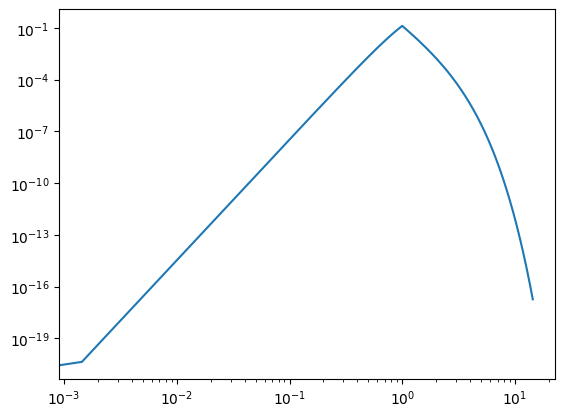

In [ ]:
x = np.linspace(0,14.39,10000,endpoint=False)
y = np.array([function(i) for i in x])
plt.loglog(x,y)


3) The integral goes to ∞. So we have to discard part of the integral and numerically
compute ∫ a
0
f (x)dx
What value of a will a good choice? Can you analytically bound
∫ ∞
a
f (x)dx
for large a? Hint: The Bessel functions all have approximations in terms of
complex exponentials for large arguments.

In [ ]:
a = 20*np.log(10)/(2*g)
a

19.18820910828372

4) Use Python’s built-in integrator, quad, found in scipy.integrate to do the
integration. Verify the given solution. How many calls were required? (Integrate
from 0 to a).
• You need to define the integrand as a Python function.
• The function form depends on whether u < 1 or u > 1.
• Ask for full output, and look at scipy.integrate.quad_explain()
for details. One of the outputs is the number of calls made to the function.

In [ ]:
import scipy.integrate as integrate
real_int = integrate.quad(function,0,a,full_output=1)
real_int

(0.046038860334871576,
 1.3668077357420483e-08,
 {'neval': 651,
  'last': 16,
  'iord': array([          1,           5,           4,           8,           7,
                   9,          10,           3,          11,          12,
                  13,           6,           2,          14,          15,
                  16, -1929310544,       31607, -1929581536,       31607,
         -1175395875,  1557116484, -1895359952,       31607, -1929702512,
               31607, -1993253946, -1112349616,  -734993616,       31607,
         -1929576784,       31607,   234003479, -1493204764,  -734986736,
               31607, -1929576640,       31607,          49,           0,
          1829870720,       22164,  1836527840,       22164,  -587076384,
               31607,  -587076384,       31607,         208,           0],
        dtype=int32),
  'alist': array([9.99581084e-001, 9.59410455e+000, 4.79705228e+000, 2.39852614e+000,
         1.19926307e+000, 0.00000000e+000, 5.99631535e-001, 1.049

5. Use the trapezoidal method and obtain the integral. How does the error scale with
h? (See the above example code for how to use the trapzd routine in module
romberg. Does it matter if r = 1 is one of the r j values or if it lies between some
r j and r j+1?
• Define a global variable ’count’ to keep track of how many calls have been
made (I discussed global variables in python, in class).
• Plot the error (defined as difference between the numerical integral and the
theoretical value) on the y axis and number of calls on the x axis. What sort
of plot should you use?
• What is the trend? How good is the trapzoidal algorithm?

In [ ]:
from scipy import *
from matplotlib.pyplot import *
import scipy.special as sp
import romberg_module as r
import numpy as np
# integrate sin(x) as a test
s=0.0 # initialize the integral to zero
I0=real_int[0]# the exact value to compare with
int_params = []
print("i\tI[i]\tError")# print a heading
for i in range(1,20):
    s=r.trapzd(lambda x:function(x),0,a,s,i)
    calls = 1 if i == 1 else 2**(i - 1) + 1
    int_params.append((i,s,abs(s-I0),calls))
int_params


i	I[i]	Error


[(1, 1.5370464846961212e-21, 0.046038860334871576, 1),
 (2, 2.1913805784034346e-11, 0.04603886031295777, 3),
 (3, 2.118848449792694e-06, 0.046036741486421784, 5),
 (4, 0.0010500881986922404, 0.044988772136179335, 9),
 (5, 0.05491704231651476, 0.008878181981643182, 17),
 (6, 0.03365239860393362, 0.012386461730937957, 33),
 (7, 0.04306587815833167, 0.0029729821765399067, 65),
 (8, 0.04516161765388456, 0.0008772426809870171, 129),
 (9, 0.04582204697683668, 0.0002168133580348966, 257),
 (10, 0.04598999177401701, 4.88685608545647e-05, 513),
 (11, 0.04602321341221491, 1.564692265666745e-05, 1025),
 (12, 0.046037073725828985, 1.7866090425908143e-06, 2049),
 (13, 0.04603762615769702, 1.2341771745555397e-06, 4097),
 (14, 0.04603923836109508, 3.7802622350480153e-07, 8193),
 (15, 0.0460389021924411, 4.1857569521575044e-08, 16385),
 (16, 0.046038851593091686, 8.741779890242274e-09, 32769),
 (17, 0.046038855664770624, 4.670100951786882e-09, 65537),
 (18, 0.04603886097602103, 6.411494529734441e-10, 

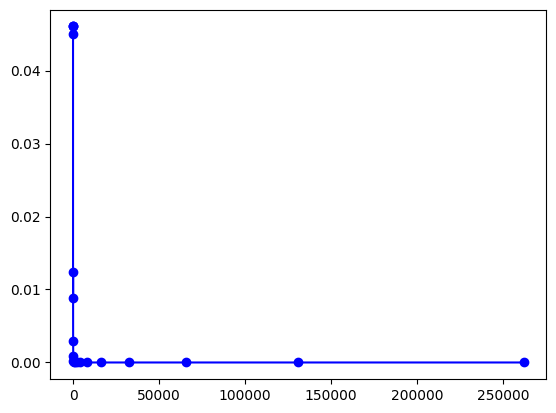

In [ ]:
tr_calls = [int_params[i][3] for i in range(len(int_params))]
tr_errors =[int_params[i][2] for i in range(len(int_params))]
plt.plot(tr_calls,tr_errors,"bo-")

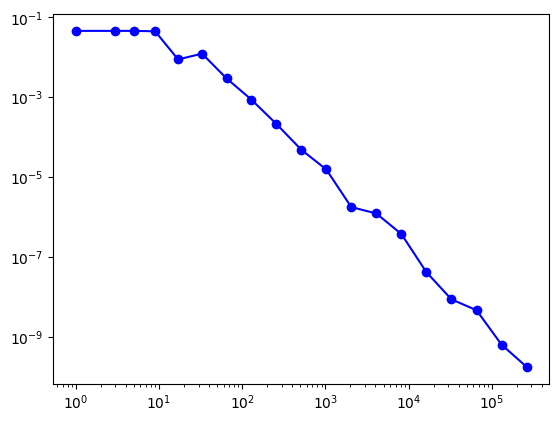

In [ ]:
plt.loglog(tr_calls,tr_errors,"bo-",)

6. Use the romberg module’s qromb to investigate Romberg integration. Integrate
the entire integral from 0 to ∞. How does the error scale with number of calls?
Plot the trend

In [ ]:
from scipy import *
from matplotlib.pyplot import *
import scipy.special as sp
import romberg_module as r
import numpy as np
# integrate sin(x) as a test
s=0.0 # initialize the integral to zero
I0=real_int[0]# the exact value to compare with
int_params = []
print("i\tI[i]\tError")# print a heading
s,dss,numcalls=r.qromb(lambda x:function(x),0,a,[10^(-11),5])


i	I[i]	Error


In [ ]:
dss

2.414417508971302e-12

In [ ]:
qromb_num_calls=[]
qromb_error= []
for i in np.logspace(-1, -10, num=20, endpoint=True):
  s,dss,numcalls=r.qromb(function,0,a,eps=i)
  qromb_num_calls.append(numcalls)
  qromb_error.append(abs(s-I0))

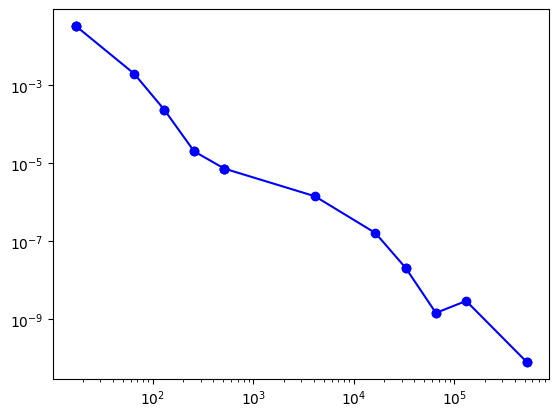

In [ ]:
plt.loglog(qromb_num_calls,qromb_error,"bo-")

7. Split the romberg integrals into (0, 1) and (1, ∞). Repeat the study. Explain the
difference in the number of calls required to achieve a given accuracy.

In [ ]:
I00 =integrate.quad(function,0,1,full_output=1)[0]
I01 =integrate.quad(function,1,a,full_output=1)[0]


In [ ]:
qromb_split_num_calls=[]
qromb_split_error=[]
for i in np.logspace(-1, -10, num=20, endpoint=True):
  s1,dss1,numcalls1=r.qromb(function,0,1,eps=i)
  s2,dss1,numcalls2=r.qromb(function,1,a,eps=i)

  qromb_split_num_calls.append(numcalls1+numcalls2)
  qromb_split_error.append(abs(s1+s2-I0))


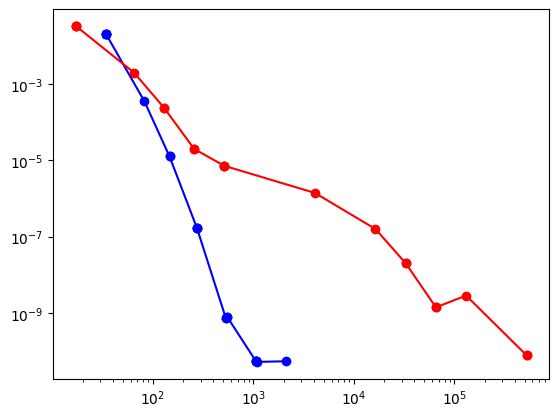

In [ ]:
plt.loglog(qromb_split_num_calls,qromb_split_error,"bo-",qromb_num_calls,qromb_error,"ro-")

In [ ]:
# Assuming romberg.polint is available for polynomial interpolation
# polint(xx, yy, x) interpolates a polynomial through points (xx, yy) at x

def new_trapzd(func, a, b, s_old, n, div=2):
    """
    Parameters:
    func : Evaluation Function (func->float)
    a : Lower limit (int, float)
    b : Upper Limit (int, float)
    s_old : Previously computed Integral value (float)
    n : Current iteration (int)
    div : Division factor for the step size (default is 3)

    Returns:
    s_new : Computed Integral Value for the current iteration (float)
    """
    h = (b-a)

    if n == 1:  # First iteration, use basic trapezoidal rule
        return 0.5 * (func(a) + func(b)) * h

    s_new = 0
    k = pow(div, n)

    # Iterate through all the new points introduced by refining the step
    for cnt in range(1, k):
        if cnt % div == 0:  # Skip points already used in previous iterations
            continue
        s_new += func(a + cnt * h / k)

    return s_new * h / k + s_old / div  # Combine old and new sum


def new_trapzd_wrapper(func, a, b, n, div=2):
    """
    A wrapper function to compute the integral value using the divide-by-3 trapezoidal rule.

    Parameters:
    func : Evaluation Function
    a : Lower limit
    b : Upper limit
    n : Number of iterations
    div : Division factor for the step size (default is 3)

    Returns:
    s : Final integral value
    func_calls : Total number of function calls
    """
    s = 0
    func_calls = pow(div, n-1) + 1  # Initial number of function calls

    for i in range(1, n):  # Iterate through n iterations
        s = new_trapzd(func, a, b, s, i, div)

    return s, func_calls



def qromb_2(func, a, b, eps=pow(10, -6), k=5, div=2):
    """
    Romberg integration with divide-by-3 trapezoidal rule.

    Parameters:
    func : Evaluation function
    a : Lower limit
    b : Upper limit
    eps : Desired accuracy (default 1e-6)
    k : Order of extrapolation (default 5)
    div : Division factor for step size (default 3)

    Returns:
    y : Final integral value
    err : Estimated error
    numcalls : Number of function calls
    """
    h = (b - a)
    imax = 20  # Maximum iterations
    xx = []  # Step sizes squared
    yy = []  # Integral estimates
    s = 0  # Initial integral sum

    # Iteratively apply trapezoidal rule and Romberg extrapolation
    for i in range(imax):
        j = i + 1
        s = new_trapzd(func, a, b, s, j, div)  # Compute integral for current iteration

        xx.append((h / pow(div, i))**2)  # Store step size squared
        yy.append(s)  # Store integral estimate

        if j > k:  # Start extrapolation when we have enough points
            y, err = r.polint(xx[-k:], yy[-k:], 0)  # Polynomial interpolation

            if abs(err) <= eps * abs(y):  # Check if error meets tolerance
                numcalls = pow(div, i) + 1  # Number of function calls
                return y, err, numcalls

    # If maximum iterations reached
    numcalls = -1  # Error case
    return y, err, numcalls


In [ ]:
qromb1_num_calls=[]
qromb1_error=[]
for i in np.logspace(-1, -10, num=20, endpoint=True):
  s1,dss1,numcalls1=qromb_2(function,0,1,eps=i)
  s2,dss1,numcalls2=qromb_2(function,1,a,eps=i)

  qromb1_num_calls.append(numcalls1+numcalls2)
  qromb1_error.append(abs(s1+s2-I0))

In [ ]:
plt.loglog(qromb1_num_calls,qromb1_error,"bo-")

9. Vary the order of qromb and see how the number of calls scales for a fixed error
of 10−8.

In [ ]:
qromb_split_num_calls=[]
qromb_split_order=[]
for i in range(2,30):
  s1,dss1,numcalls1=r.qromb(function,0,20,eps=10e-8,k=i)
  qromb_split_num_calls.append(numcalls1)
  qromb_split_order.append(i)

Text(0.5, 0, 'Order')

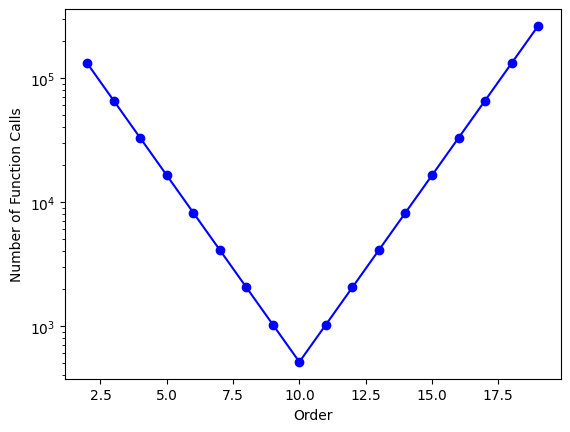

In [ ]:
plt.semilogy(qromb_split_order,qromb_split_num_calls,"bo-")
plt.ylabel("Number of Function Calls")
plt.xlabel("Order")



Use spline integration to improve over trapezoidal integration. What scaling do
you get (plot it!)? Can you explain why? Hint: Look at the spline interpolated
function near r = 1.
Note that simple spline integration is a trivial use of the B-Spline routines in
scipy. To get the trivial splines, use
import scipy.interpolate as si
tck=si.splrep(x,y) # x,y contains table of data
This generates cubic splines that correspond to the curve that passes exactly
through the points. To interpolate, use
yy=si.splev(xx,tck) ## xx contains points at which to interpolate
To integrate, use
I=si.splint(a,b,tck)
These all effectively use the not-a-knot boundary condition.
B-Splines can do much more. They can give smooth curves that give more im-
portance to certain points and minimize the least-squares error of the fit.

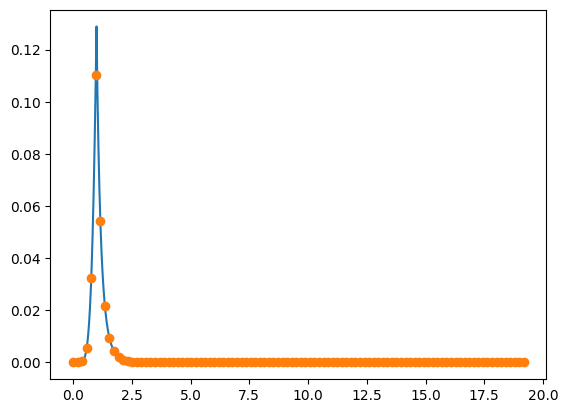

In [ ]:
import scipy.interpolate as si
xx = np.linspace(0,a,10000,endpoint=False)
yy = np.array([function(i) for i in xx])
tck=si.splrep(xx,yy)
x= np.linspace(0,a,100)
y=si.splev(x,tck)
plt.plot(xx,yy,"",x,y,"o")

Text(0, 0.5, 'Error')

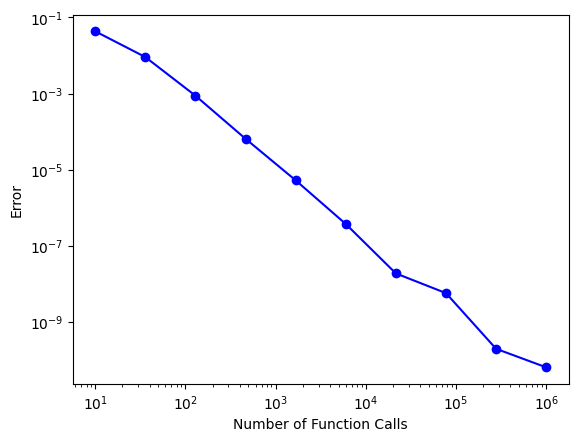

In [ ]:
spline_num_class =[]
spline_error =[]
for num_class in np.logspace(1,6,10,endpoint=True):
  x= np.linspace(0,a,int(num_class),endpoint=True)
  y=np.array([function(i) for i in x])
  tck=si.splrep(x,y)
  y=si.splint(0,a,tck)
  error = abs(y-I0)
  spline_num_class.append(num_class)
  spline_error.append(error)

plt.loglog(spline_num_class,spline_error,"bo-")
plt.xlabel("Number of Function Calls")
plt.ylabel("Error")


11. Break up the spline integration into two separate parts, from 0 to 1 and from 1 to
umax. How do the scalings change (plot ...)? What does this tell us about spline
fitting and spline integration?

Text(0, 0.5, 'Error')

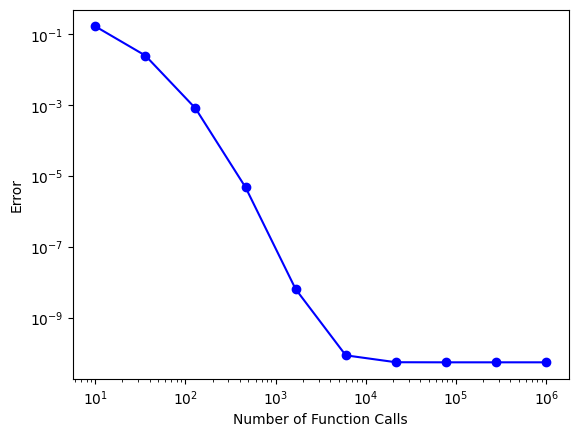

In [ ]:
split_spline_num_class =[]
split_spline_error =[]
for num_class in np.logspace(1,6,10,endpoint=True):
  x= np.linspace(0,1,int(num_class)//2,endpoint=True)
  y=np.array([function(i) for i in x])
  tck=si.splrep(x,y)
  y1=si.splint(0,1,tck)

  x= np.linspace(1,a,int(num_class)//2,endpoint=True)
  y=np.array([function(i) for i in x])
  tck=si.splrep(x,y)
  y2=si.splint(1,a,tck)
  y=y1+y2
  error = abs(y-I0)
  split_spline_num_class.append(num_class)
  split_spline_error.append(error)

plt.loglog(split_spline_num_class,split_spline_error,"bo-")
plt.xlabel("Number of Function Calls")
plt.ylabel("Error")


In [ ]:
# Assuming romberg.polint is available for polynomial interpolation
# polint(xx, yy, x) interpolates a polynomial through points (xx, yy) at x

def new_trapzd(func, a, b, s_old, n, div=3):
    """
    Parameters:
    func : Evaluation Function (func->float)
    a : Lower limit (int, float)
    b : Upper Limit (int, float)
    s_old : Previously computed Integral value (float)
    n : Current iteration (int)
    div : Division factor for the step size (default is 3)

    Returns:
    s_new : Computed Integral Value for the current iteration (float)
    """
    h = (b-a)

    if n == 1:  # First iteration, use basic trapezoidal rule
        return 0.5 * (func(a) + func(b)) * h

    s_new = 0
    k = pow(div, n)

    # Iterate through all the new points introduced by refining the step
    for cnt in range(1, k):
        if cnt % div == 0:  # Skip points already used in previous iterations
            continue
        s_new += func(a + cnt * h / k)

    return s_new * h / k + s_old / div  # Combine old and new sum


def new_trapzd_wrapper(func, a, b, n, div=3):
    """
    A wrapper function to compute the integral value using the divide-by-3 trapezoidal rule.

    Parameters:
    func : Evaluation Function
    a : Lower limit
    b : Upper limit
    n : Number of iterations
    div : Division factor for the step size (default is 3)

    Returns:
    s : Final integral value
    func_calls : Total number of function calls
    """
    s = 0
    func_calls = pow(div, n-1) + 1  # Initial number of function calls

    for i in range(1, n):  # Iterate through n iterations
        s = new_trapzd(func, a, b, s, i, div)

    return s, func_calls



def qromb_3(func, a, b, eps=pow(10, -6), k=5, div=3):
    """
    Romberg integration with divide-by-3 trapezoidal rule.

    Parameters:
    func : Evaluation function
    a : Lower limit
    b : Upper limit
    eps : Desired accuracy (default 1e-6)
    k : Order of extrapolation (default 5)
    div : Division factor for step size (default 3)

    Returns:
    y : Final integral value
    err : Estimated error
    numcalls : Number of function calls
    """
    h = (b - a)
    imax = 20  # Maximum iterations
    xx = []  # Step sizes squared
    yy = []  # Integral estimates
    s = 0  # Initial integral sum

    # Iteratively apply trapezoidal rule and Romberg extrapolation
    for i in range(imax):
        j = i + 1
        s = new_trapzd(func, a, b, s, j, div)  # Compute integral for current iteration

        xx.append((h / pow(div, i))**2)  # Store step size squared
        yy.append(s)  # Store integral estimate

        if j > k:  # Start extrapolation when we have enough points
            y, err = r.polint(xx[-k:], yy[-k:], 0)  # Polynomial interpolation

            if abs(err) <= eps * abs(y):  # Check if error meets tolerance
                numcalls = pow(div, i) + 1  # Number of function calls
                return y, err, numcalls

    # If maximum iterations reached
    numcalls = -1  # Error case
    return y, err, numcalls



In [ ]:
s,dss,numcalls=qromb_3(function,0,a)
print(s-I0)

-0.4136613887210075


In [ ]:
div3_qromb_num_calls=[]
div3_qromb_error= []
for i in np.logspace(-1, -10, num=20, endpoint=True):
  s1,dss,numcalls1=qromb_3(function,0,1,eps=i)
  s2,dss,numcalls2=qromb_3(function,1,a,eps=i)
  div3_qromb_num_calls.append(numcalls1 +numcalls2)
  div3_qromb_error.append(abs(s1+s2-I0))

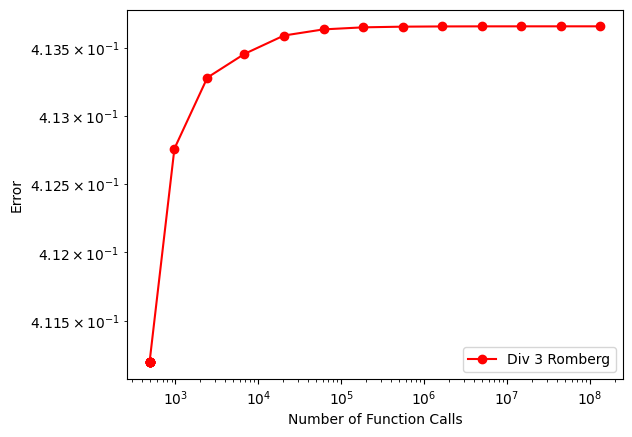

In [ ]:
plt.loglog(div3_qromb_num_calls,div3_qromb_error,"ro-")
plt.xlabel("Number of Function Calls")
plt.ylabel("Error")
plt.legend(["Div 3 Romberg"])

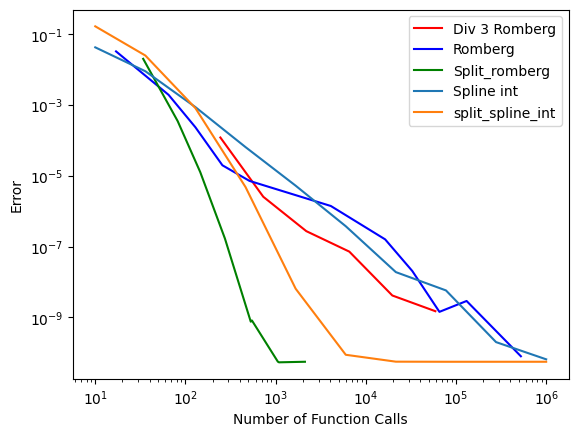

In [ ]:
plt.loglog(div3_qromb_num_calls,div3_qromb_error,"r",qromb_num_calls,qromb_error,"b",qromb_split_num_calls,qromb_split_error,"g",spline_num_class,spline_error,"",split_spline_num_class,split_spline_error,'')
plt.xlabel("Number of Function Calls")
plt.ylabel("Error")
plt.legend(["Div 3 Romberg","Romberg","Split_romberg","Spline int", "split_spline_int"])